In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import datetime
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr
from matplotlib import cm

def is_weekday(date_string):
    date_obj = datetime.datetime.strptime(date_string[:25], "Date: %Y-%m-%d %H:%M:%S")
    return date_obj.weekday() < 5

def get_travel_data(year,depart_hour_range=None,weight_column=None,weekday="All",origin_purp="All",dest_purp="All"):
    df = pd.read_csv("psrc_trips.csv")
    # df = df[(df["d_tract10"].astype(str).str[2:5]=="033")&(df["o_tract10"].astype(str).str[2:5]=="033")]
    df = df[df['depart_time_string'].str[6:10].notna() & df['depart_time_string'].str[17:19].notna()]
    df_2021 = df[(df['depart_time_string'].str[6:10] == str(year))]
    if depart_hour_range != None:
        df_2021 = df_2021[df_2021['depart_time_string'].str[17:19].astype(int).between(*depart_hour_range)]
    df_2021 = df_2021[["o_tract10","d_tract10","origin_purpose_cat","dest_purpose_cat",'depart_time_string',"arrival_time_string","trip_adult_weight_2021","trip_respondent_weight_2021",
                    "trip_weight_2017","trip_weight_2019","trip_weight_2017_2019","trip_adult_weight_2017_2019"]]
    if weight_column == None:
        if year == 2021:
            weight_column = "trip_respondent_weight_2021"
        elif year == 2019:
            weight_column = "trip_weight_2019"
        elif year == 2017:
            weight_column = "trip_weight_2017"
    if weekday=="All":
        pass
    elif weekday==True:
        df_2021 = df_2021[df_2021["depart_time_string"].apply(is_weekday)]
    elif weekday==False:
        df_2021 = df_2021[df_2021["depart_time_string"].apply(is_weekday)]
    if origin_purp=="All":
        pass
    else:
        df_2021 = df_2021[df_2021["origin_purpose_cat"]==origin_purp]
    if dest_purp=="All":
        pass
    else:
        df_2021 = df_2021[df_2021["dest_purpose_cat"]==dest_purp]
    df_2021["d_tract10"] = df_2021["d_tract10"].astype(str).str[:-2]
    df_2021["o_tract10"] = df_2021["o_tract10"].astype(str).str[:-2]
    unique_elements = set(df_2021['o_tract10']).union(set(df_2021['d_tract10']))
    df_2021 = df_2021.groupby(["o_tract10","d_tract10"]).sum(weight_column)
    df_2021 = df_2021.reset_index()
    table_2021 = df_2021.pivot(index='d_tract10', columns='o_tract10', \
                                values=weight_column).reindex(index=unique_elements, \
                                columns=unique_elements, fill_value=0).fillna(0)
    if 'n' in table_2021.index:
        table_2021 = table_2021.drop('n', axis=0)
    if 'n' in table_2021.columns:
        table_2021 = table_2021.drop('n', axis=1)
    table_2021 = table_2021 - table_2021.T
    table_2021_numpy = table_2021.to_numpy()
    table_2021_numpy = np.where(table_2021_numpy < 0, 0, table_2021_numpy)
    non_zero_entries = table_2021_numpy.nonzero()
    non_zero_df = pd.DataFrame({
        'Destination': [table_2021.index[i] for i in non_zero_entries[0]],
        'Origin': [table_2021.columns[i] for i in non_zero_entries[1]],
        'Value': table_2021.to_numpy()[non_zero_entries]
    })
    nodes_list = set(non_zero_df["Destination"]).union(set(non_zero_df["Origin"]))
    edges_dict = {(row[1],row[0]):row[2] for index, row in non_zero_df.iterrows()}
    return nodes_list, edges_dict

def delete_element(lst, i):
    lst.pop(i)
    return lst

def generate_circle_positions(n, radius=5):
    positions = {}
    for i in range(n):
        angle = 2 * math.pi * i / n
        x = radius * math.cos(angle)
        y = radius * math.sin(angle)
        positions[i] = (x, y)
    return positions

def build_graph(nodes,edge_dict):
    internal_nodes_dict = {i:idx+1 for idx,i in enumerate(nodes)}
    internal_edges_dict = {(internal_nodes_dict[edge[0]],internal_nodes_dict[edge[1]]):weight for edge,weight in edge_dict.items()}
    G = nx.Graph()
    G.add_nodes_from(internal_nodes_dict.values())
    for edge in internal_edges_dict.keys():
        src, dst = edge
        weight = internal_edges_dict.get((src, dst))
        if dst > src:
            G.add_edge(src, dst, weight=weight)
        elif dst < src:
            G.add_edge(src, dst, weight=(-1)*weight)
        else:
            pass
    return G, internal_nodes_dict

def get_vertex_by_edge_boundary(G):
    vertices = list(G.nodes)
    edges = list(G.edges)
    vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)
    return vertex_by_edge_boundary,vertices,edges

def get_edge_by_triangle_boundary(G):
    edges = list(G.edges)
    triangles = [tuple(clique) for clique in nx.enumerate_all_cliques(G) if len(clique) == 3]
    edges_dict = {edge:idx for idx,edge in enumerate(edges)}
    triangles_dict = {triangle:idx for idx,triangle in enumerate(triangles)}
    data = []
    row_indices = []
    col_indices = []
    for triangle in triangles:
        col_idx = triangles_dict[triangle]
        row_indices.append(edges_dict[(triangle[1],triangle[2])])
        row_indices.append(edges_dict[(triangle[0],triangle[2])])
        row_indices.append(edges_dict[(triangle[0],triangle[1])])
        col_indices.append(col_idx)
        col_indices.append(col_idx)
        col_indices.append(col_idx)
        data.append(1)
        data.append(-1)
        data.append(1)
    data = np.array(data)
    row_indices = np.array(row_indices)
    col_indices = np.array(col_indices)
    edge_by_triangle_boundary = csc_matrix((data, (row_indices, col_indices)), shape=(len(edges), len(triangles)))
    return edge_by_triangle_boundary,edges,triangles

def get_k_simplex_by_k_plus_1_simplex_boundary(G,k):
    k_simplicies = [tuple(clique) for clique in nx.enumerate_all_cliques(G) if len(clique) == k+1]
    k_plus_1_simplicies = [tuple(clique) for clique in nx.enumerate_all_cliques(G) if len(clique) == k+2]
    k_simplicies_dict = {k_simplex:idx for idx,k_simplex in enumerate(k_simplicies)}
    k_plus_1_simplicies_dict = {k_plus_1_simplex:idx for idx,k_plus_1_simplex in enumerate(k_plus_1_simplicies)}
    data = []
    row_indices = []
    col_indices = []
    for k_plus_1_simplex in k_plus_1_simplicies:
        col_idx = k_plus_1_simplicies_dict[k_plus_1_simplex]
        for i in range(len(k_plus_1_simplex)):
            row_indices.append(k_simplicies_dict[tuple(delete_element(list(k_plus_1_simplex),i))])
            col_indices.append(col_idx)
            data.append((-1)**(i))
    data = np.array(data)
    row_indices = np.array(row_indices)
    col_indices = np.array(col_indices)
    k_simplex_by_k_plus_1_simplex_boundary = csc_matrix((data, (row_indices, col_indices)), shape=(len(k_simplicies), len(k_plus_1_simplicies)))
    return k_simplex_by_k_plus_1_simplex_boundary,k_simplicies,k_plus_1_simplicies

def get_hodge_laplacian(G,k):
    if k == 0:
        k_by_k_plus_1_bdary,k_simplcies,k_plus_1_simplicies = get_k_simplex_by_k_plus_1_simplex_boundary(G,k)
        hodge_laplacian = k_by_k_plus_1_bdary@k_by_k_plus_1_bdary.T
    elif k >= 1:
        k_by_k_plus_1_bdary,k_simplcies,k_plus_1_simplicies = get_k_simplex_by_k_plus_1_simplex_boundary(G,k)
        k_minus_1_by_k_bdary,k_minus_1_simplcies,k_simplicies = get_k_simplex_by_k_plus_1_simplex_boundary(G,k-1)
        hodge_laplacian = k_minus_1_by_k_bdary.T@k_minus_1_by_k_bdary+k_by_k_plus_1_bdary@k_by_k_plus_1_bdary.T
    return hodge_laplacian

def get_graph_laplacian(G):
    return get_hodge_laplacian(G,0)

def get_graph_helmholtzian(G):
    return get_hodge_laplacian(G,1)

def get_graph_hodge_decomposition(nodes,edge_dict):
    G, internal_nodes_dict = build_graph(nodes,edge_dict)
    edge_flows = np.array([data['weight'] for _, _, data in G.edges(data=True)]).T
    vertex_by_edge_boundary,vertices,edges = get_vertex_by_edge_boundary(G)
    edge_by_triangle_boundary,edges,triangles = get_edge_by_triangle_boundary(G)
    graph_helmholtzian = get_graph_helmholtzian(G)
    vertices_potential = lsqr(vertex_by_edge_boundary.T, edge_flows)[0]
    vertices_potential = vertices_potential-min(vertices_potential)
    gradient_component = vertex_by_edge_boundary.T@vertices_potential
    triangles_curl = np.linalg.pinv(edge_by_triangle_boundary)@edge_flows
    triangles_curl = lsqr(edge_by_triangle_boundary, edge_flows)[0]
    curl_adjoint_component = edge_by_triangle_boundary@triangles_curl
    graph_helmholtzian_kernel_component = (np.eye(len(edges))-graph_helmholtzian@np.linalg.pinv(graph_helmholtzian))@edge_flows
    three_components = (gradient_component,graph_helmholtzian_kernel_component,curl_adjoint_component)
    three_matrices = (vertex_by_edge_boundary,graph_helmholtzian,edge_by_triangle_boundary)
    return three_components, three_matrices, (vertices_potential,triangles_curl), (vertices,edges,triangles), internal_nodes_dict, edge_flows

def get_graph_closest_potential(nodes,edge_dict):
    G, internal_nodes_dict = build_graph(nodes,edge_dict)
    edge_flows = np.array([data['weight'] for _, _, data in G.edges(data=True)]).T
    vertex_by_edge_boundary,vertices,edges = get_vertex_by_edge_boundary(G)
    vertices_potential = lsqr(vertex_by_edge_boundary.T, edge_flows)[0]
    vertices_potential = vertices_potential-min(vertices_potential)
    gradient_component = vertex_by_edge_boundary.T@vertices_potential
    return gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows

def plot_urban_potential(year,weight_column=None,depart_hour_range=None,weekday="All",origin_purp="All",dest_purp="All"):
    nodes,edge_dict = get_travel_data(year=year,depart_hour_range=depart_hour_range,weight_column=weight_column,weekday=weekday,origin_purp=origin_purp,dest_purp=dest_purp)
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'census tracts 2010/tract10.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID10"].isin(vertices_potential_dict.keys())]
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID10", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.1), vmax=np.quantile(potential_vals, 0.9))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    if depart_hour_range != None:
        plt.title(f"{str(year)} {str(depart_hour_range[0])}:00:00 to {str(depart_hour_range[1])}:00:00 Census Tract Potentials (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    else:
        plt.title(f"{str(year)} Census Tract Potentials (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    if depart_hour_range != None:
        plt.title(f"Histogram of Census Tract Potential Values {str(year)} {str(depart_hour_range[0])}:00:00 to {str(depart_hour_range[1])}:00:00 (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    else:
        plt.title(f"Histogram of Census Tract Potential Values {str(year)} (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence(year,weight_column=None,depart_hour_range=None,weekday="All",origin_purp="All",dest_purp="All"):
    nodes,edge_dict = get_travel_data(year=year,depart_hour_range=depart_hour_range,weight_column=weight_column,weekday=weekday,origin_purp=origin_purp,dest_purp=dest_purp)
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values()
        })
    shapefile_path = 'census tracts 2010/tract10.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID10"].isin(vertices_divergence_dict.keys())]
    gdf_10_2 = gdf_10.merge(vertices_divergence_df, left_on="GEOID10", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    divergence_vals = list(vertices_divergence_dict.values())
    norm = Normalize(vmin=np.quantile(divergence_vals, 0.1), vmax=np.quantile(divergence_vals, 0.9))
    gdf_10_2.plot(figsize=(12, 11),column="Divergence", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    if depart_hour_range != None:
        plt.title(f"{str(year)} {str(depart_hour_range[0])}:00:00 to {str(depart_hour_range[1])}:00:00 Census Tract Divergences (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    else:
        plt.title(f"{str(year)} Census Tract Divergences (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_divergence_dict.values(), bins=300, color='blue', edgecolor='black')
    if depart_hour_range != None:
        plt.title(f"Histogram of Census Tract Divergence Values {str(year)} {str(depart_hour_range[0])}:00:00 to {str(depart_hour_range[1])}:00:00 (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    else:
        plt.title(f"Histogram of Census Tract Divergence Values {str(year)} (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    plt.xlabel("Census Tract Divergence Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [34]:
def get_travel_data_2():
    df = pd.read_csv("ca_od_main_JT00_2019.csv")
    fips_dict = {"San Francisco":6075,"Sonoma":6097 ,"Solano":6095 ,"Santa Clara":6085,"San Mateo":6081,"Napa":6055,"Marin":6041,"Contra Costa":6013,"Alameda":6001}
    fips_list = list(str(i) for i in fips_dict.values())
    df["w_geocode_first5_str"] = df["w_geocode"].astype(str).str[:4]
    df["h_geocode_first5_str"] = df["h_geocode"].astype(str).str[:4]
    df = df[df["h_geocode_first5_str"].isin(fips_list) & df["w_geocode_first5_str"].isin(fips_list)]
    df = df[["w_geocode","h_geocode","S000"]]
    df["w_geocode_first11_str"] = df["w_geocode"].astype(str).str[:10]
    df["h_geocode_first11_str"] = df["h_geocode"].astype(str).str[:10]
    df = df.groupby(["w_geocode_first11_str","h_geocode_first11_str"])['S000'].sum().reset_index()
    # df = df[df["S000"]>3]
    df["w_geocode_first11_str"] = df["w_geocode_first11_str"].apply(lambda x: '0' + x)
    df["h_geocode_first11_str"] = df["h_geocode_first11_str"].apply(lambda x: '0' + x)
    nodes_list = set(df["w_geocode_first11_str"]).union(set(df["h_geocode_first11_str"]))
    edges_dict = {(row[1],row[0]):row[2] for index, row in df.iterrows()}
    return nodes_list, edges_dict

def plot_urban_potential_8():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'California census tract 2019/tl_2019_06_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_dict.keys())]
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
    gdf_10_2 = gdf_10_2[~gdf_10_2["Potential"].isna()]
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.03), vmax=np.quantile(potential_vals, 0.97))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2019 Census Tract Commute Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2019")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_potential_8():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_potential_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values(),
            'Potential': vertices_potential_dict.values()
        })
    vertices_divergence_greater_potential_df = vertices_divergence_potential_df[vertices_divergence_potential_df["Divergence"]>0]
    vertices_divergence_less_potential_df = vertices_divergence_potential_df[vertices_divergence_potential_df["Divergence"]<=0]
    plt.figure(figsize=(8, 6))
    plt.scatter(vertices_divergence_greater_potential_df["Divergence"], vertices_divergence_greater_potential_df["Potential"], color='blue', marker='o',alpha=0.05)
    plt.scatter(vertices_divergence_less_potential_df["Divergence"], vertices_divergence_less_potential_df["Potential"], color='red', marker='o',alpha=0.05)
    plt.title(f"Histogram of Census Tract Commute Divergence and Potential Values 2021")
    plt.xlabel("Divergence")
    plt.ylabel("Potential")
    plt.xlim([-4000,10000])
    plt.ylim([-5,30])
    plt.grid(True)
    plt.show()

def get_urban_divergence_potential_8():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_potential_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values(),
            'Potential': vertices_potential_dict.values()
        })
    vertices_divergence_potential_df.to_csv("San Francisco census tract divergence potential.csv")

In [31]:
get_urban_divergence_potential_8()

C:\Users\DELL\AppData\Local\Temp\ipykernel_15200\325294744.py:105: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


C:\Users\DELL\AppData\Local\Temp\ipykernel_15200\325294744.py:105: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


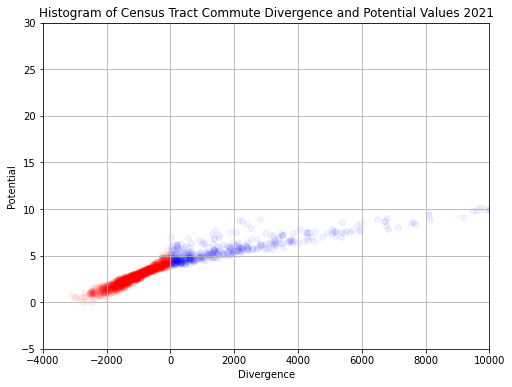

In [15]:
plot_urban_divergence_potential_8()

C:\Users\DELL\AppData\Local\Temp\ipykernel_15200\325294744.py:105: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


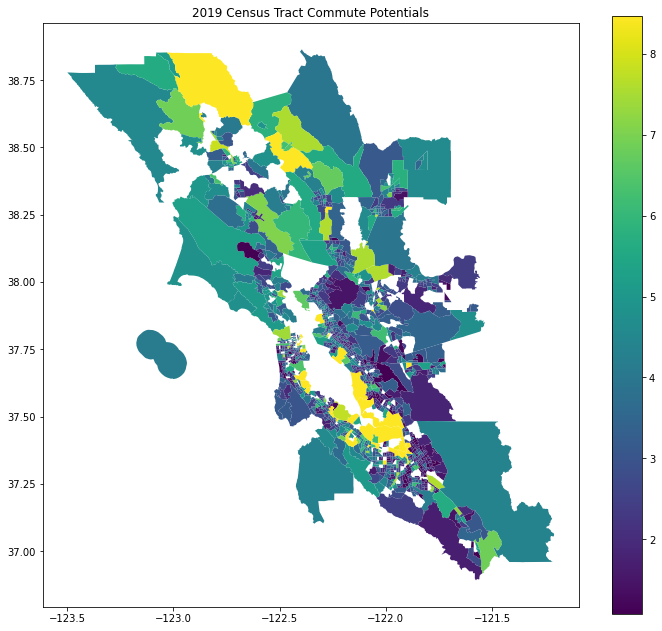

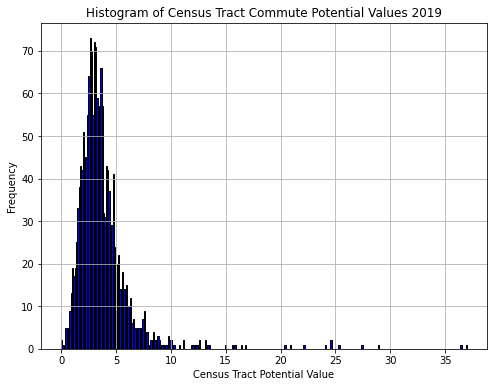

In [35]:
plot_urban_potential_8()

In [39]:
def get_travel_data_2():
    df = pd.read_csv("ca_od_main_JT00_2019.csv")
    fips_dict = {"San Francisco":6075,"Sonoma":6097 ,"Solano":6095 ,"Santa Clara":6085,"San Mateo":6081,"Napa":6055,"Marin":6041,"Contra Costa":6013,"Alameda":6001}
    fips_list = list(str(i) for i in fips_dict.values())
    df["w_geocode_first5_str"] = df["w_geocode"].astype(str).str[:4]
    df["h_geocode_first5_str"] = df["h_geocode"].astype(str).str[:4]
    df = df[df["h_geocode_first5_str"].isin(fips_list) & df["w_geocode_first5_str"].isin(fips_list)]
    df = df[["w_geocode","h_geocode","S000"]]
    df["w_geocode_first11_str"] = df["w_geocode"].astype(str).str[:10]
    df["h_geocode_first11_str"] = df["h_geocode"].astype(str).str[:10]
    df = df.groupby(["w_geocode_first11_str","h_geocode_first11_str"])['S000'].sum().reset_index()
    # df = df[df["S000"]>3]
    df["w_geocode_first11_str"] = df["w_geocode_first11_str"].apply(lambda x: '0' + x)
    df["h_geocode_first11_str"] = df["h_geocode_first11_str"].apply(lambda x: '0' + x)
    nodes_list = set(df["w_geocode_first11_str"]).union(set(df["h_geocode_first11_str"]))
    edges_dict = {(row[1],row[0]):row[2] for index, row in df.iterrows()}
    return nodes_list, edges_dict

def plot_urban_potential_8():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'California census tract 2019/tl_2019_06_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_dict.keys())]
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.01), vmax=np.quantile(potential_vals, 0.99))
    gdf_10_2.plot(figsize=(20, 20),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.xlim([-122.75,-121.75])
    plt.ylim([37.1,38])
    plt.title(f"2019 Census Tract Commute Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2019")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_potential_8():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_potential_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values(),
            'Potential': vertices_potential_dict.values()
        })
    vertices_divergence_greater_potential_df = vertices_divergence_potential_df[vertices_divergence_potential_df["Divergence"]>0]
    vertices_divergence_less_potential_df = vertices_divergence_potential_df[vertices_divergence_potential_df["Divergence"]<=0]
    plt.figure(figsize=(8, 6))
    plt.scatter(vertices_divergence_greater_potential_df["Divergence"], vertices_divergence_greater_potential_df["Potential"], color='blue', marker='o',alpha=0.05)
    plt.scatter(vertices_divergence_less_potential_df["Divergence"], vertices_divergence_less_potential_df["Potential"], color='red', marker='o',alpha=0.05)
    plt.title(f"Histogram of Census Tract Commute Divergence and Potential Values 2021")
    plt.xlabel("Divergence")
    plt.ylabel("Potential")
    plt.xlim([-4000,10000])
    plt.ylim([-5,30])
    plt.grid(True)
    plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_15200\325294744.py:105: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


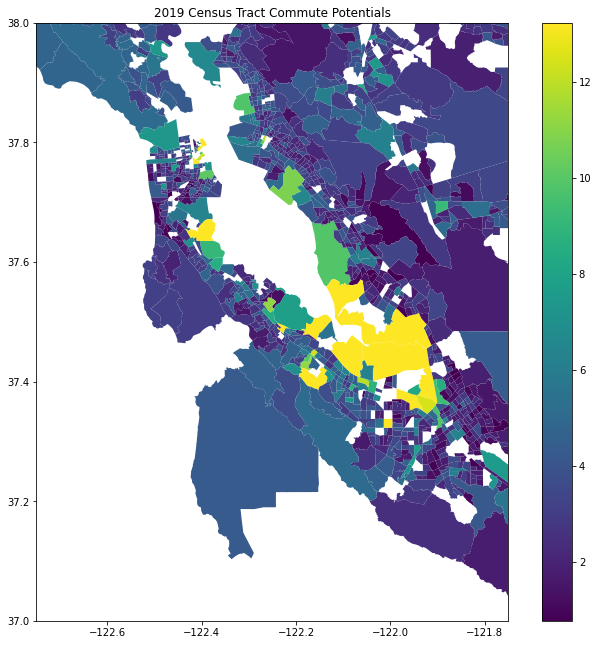

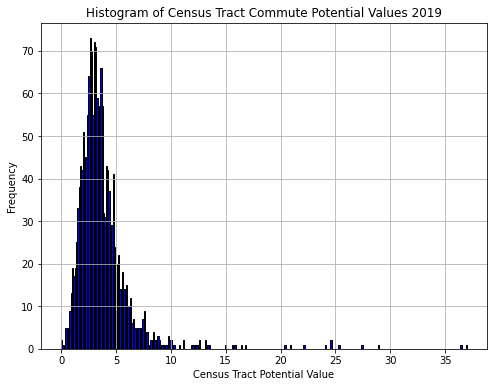

In [40]:
plot_urban_potential_8()

In [51]:
def plot_urban_potential_8():
    vertices_potential_df = pd.read_csv("divergence potential results/San Francisco census tract divergence potential.csv")
    shapefile_path = 'California census tract 2019/tl_2019_06_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_df["Census Tract"])]
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_df["Potential"])
    norm = Normalize(vmin=np.quantile(potential_vals, 0.01), vmax=np.quantile(potential_vals, 0.99))
    gdf_10_2.plot(figsize=(20, 20),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.xlim([-122.75,-121.75])
    plt.ylim([37.1,38])
    plt.title(f"2019 Census Tract Commute Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_df["Potential"], bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2019")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [48]:
vertices_potential_df = pd.read_csv("divergence potential results/San Francisco census tract divergence potential.csv")
vertices_potential_df["Census Tract"] = vertices_potential_df["Census Tract"].apply(lambda x: '0' + str(x))
vertices_potential_df = vertices_potential_df[["Census Tract","Divergence","Potential"]]
vertices_potential_df.to_csv("divergence potential results/San Francisco census tract divergence potential.csv")

In [53]:
vertices_potential_df

,Census Tract,Divergence,Potential
0,06013379000,-276.000558,4.015782
1,06001421500,-1123.997214,2.785416
2,06001442601,-1358.996036,2.265277
3,06085504413,-466.007919,3.442959
4,06085501402,-955.001870,2.757559
...,...,...,...
1760,06097153811,-250.012374,4.695315
1761,06001442700,-824.995818,3.174899
1762,06055201800,-480.960439,3.969027
1763,06001441921,-1357.000270,2.222936


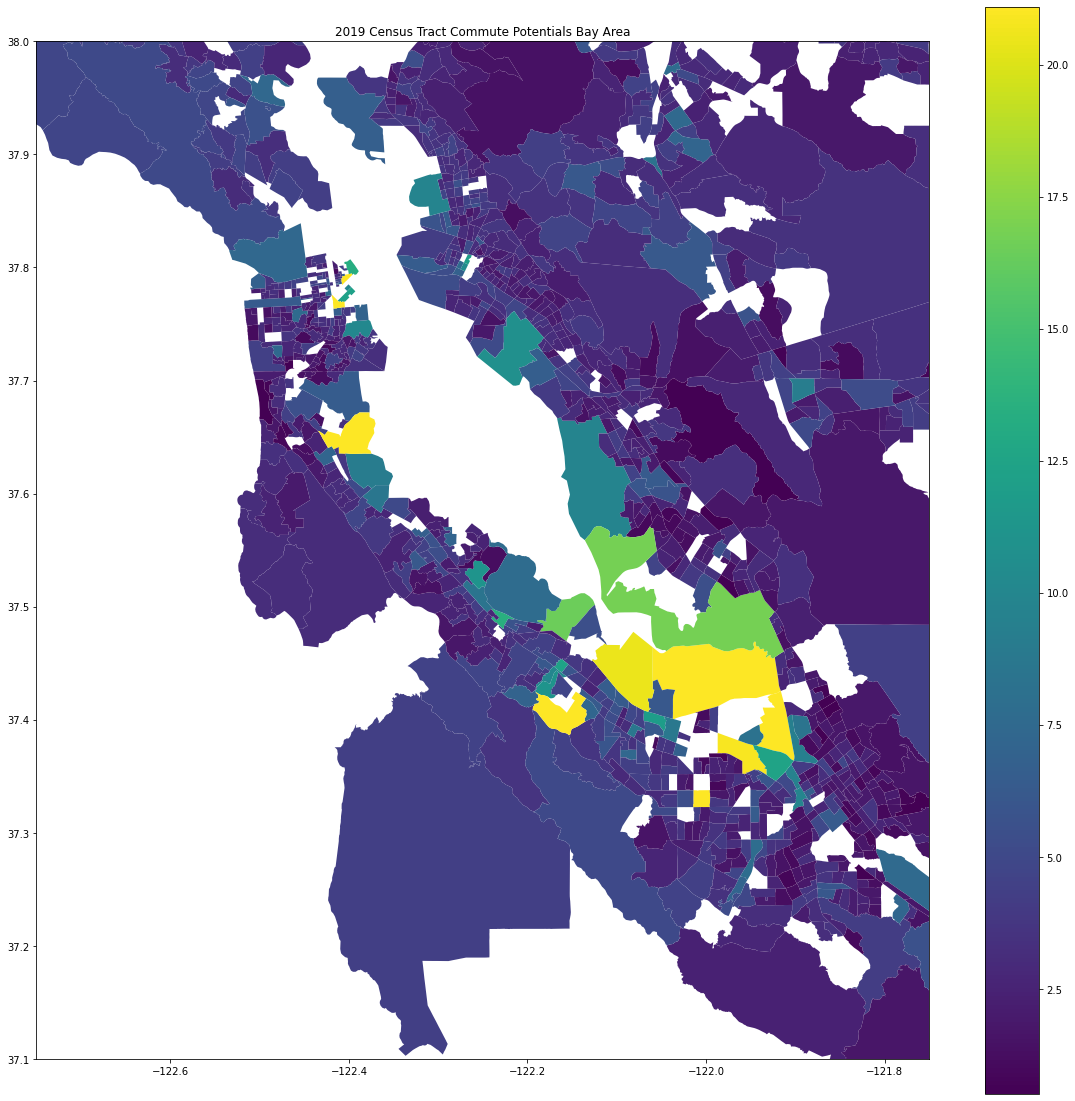

<Figure size 432x288 with 0 Axes>

In [57]:
shapefile_path = 'California census tract 2019/tl_2019_06_tract.shp'
gdf_10 = gpd.read_file(shapefile_path)
gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_df["Census Tract"])]
gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
potential_vals = list(vertices_potential_df["Potential"])
norm = Normalize(vmin=np.quantile(potential_vals, 0.005), vmax=np.quantile(potential_vals, 0.995))
gdf_10_2.plot(figsize=(20, 20),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
plt.xlim([-122.75,-121.75])
plt.ylim([37.1,38])
plt.title(f"2019 Census Tract Commute Potentials Bay Area")
plt.show()
plt.savefig('2019 Census Tract Commute Potentials Bay Area')


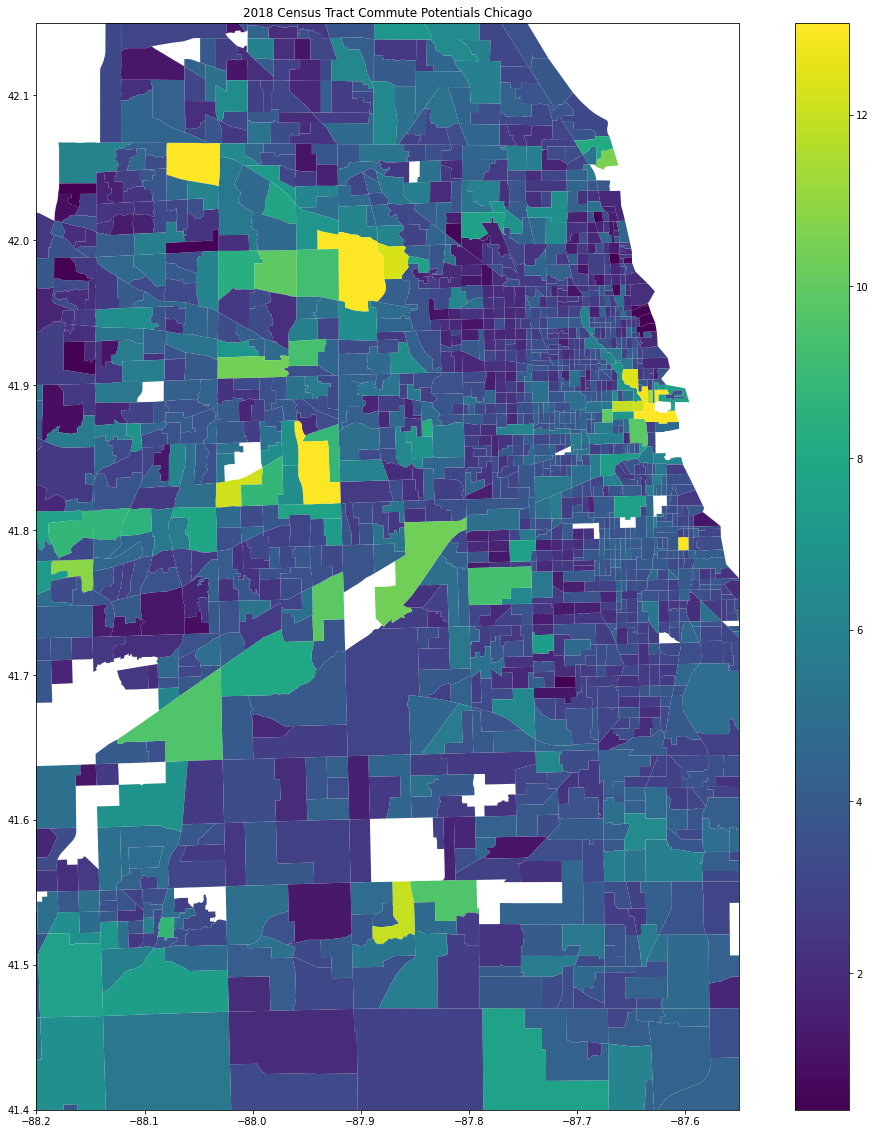

<Figure size 432x288 with 0 Axes>

In [19]:
vertices_potential_df = pd.read_csv("divergence potential results/Chicago census tract divergence potential.csv")
vertices_potential_df["Census Tract"] = vertices_potential_df["Census Tract"].astype(str)
shapefile_path = 'Illinois census tract 2018/tl_2018_17_tract.shp'
gdf_10 = gpd.read_file(shapefile_path)
gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_df["Census Tract"])]
gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
potential_vals = list(vertices_potential_df["Potential"])
norm = Normalize(vmin=np.quantile(potential_vals, 0.005), vmax=np.quantile(potential_vals, 0.995))
gdf_10_2.plot(figsize=(20, 20),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
plt.xlim([-88.2,-87.55])
plt.ylim([41.4,42.15])
plt.title(f"2018 Census Tract Commute Potentials Chicago")
plt.show()
plt.savefig('2018 Census Tract Commute Potentials Chicago')

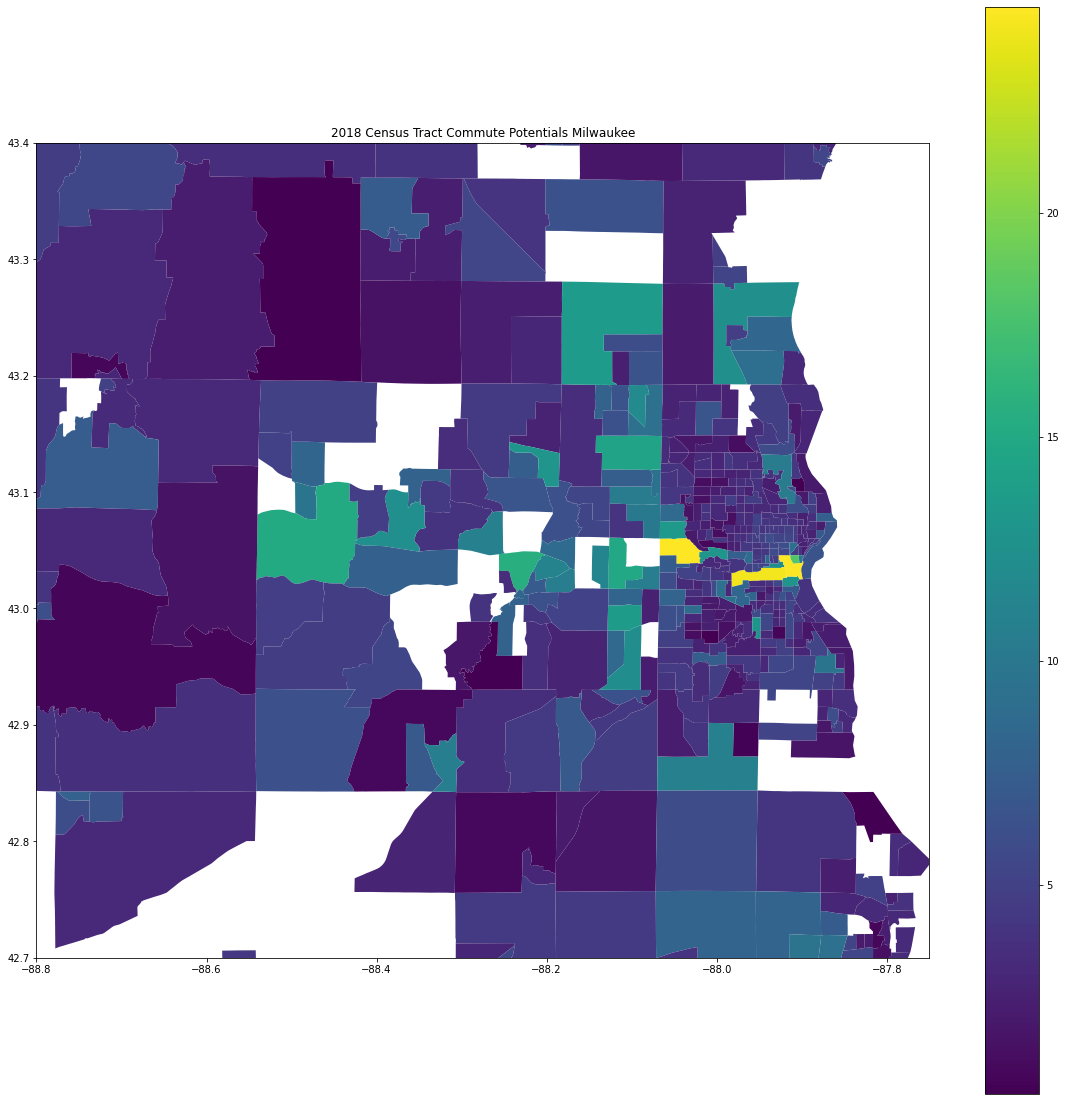

<Figure size 432x288 with 0 Axes>

In [22]:
vertices_potential_df = pd.read_csv("divergence potential results/Milwaukee census tract divergence potential.csv")
vertices_potential_df["Census Tract"] = vertices_potential_df["Census Tract"].astype(str)
shapefile_path = 'Wisconsin census tract 2018/tl_2018_55_tract.shp'
gdf_10 = gpd.read_file(shapefile_path)
gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_df["Census Tract"])]
gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
potential_vals = list(vertices_potential_df["Potential"])
norm = Normalize(vmin=np.quantile(potential_vals, 0.005), vmax=np.quantile(potential_vals, 0.995))
gdf_10_2.plot(figsize=(20, 20),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
plt.xlim([-88.8,-87.75])
plt.ylim([42.7,43.4])
plt.title(f"2018 Census Tract Commute Potentials Milwaukee")
plt.show()
plt.savefig('2018 Census Tract Commute Potentials Milwaukee')

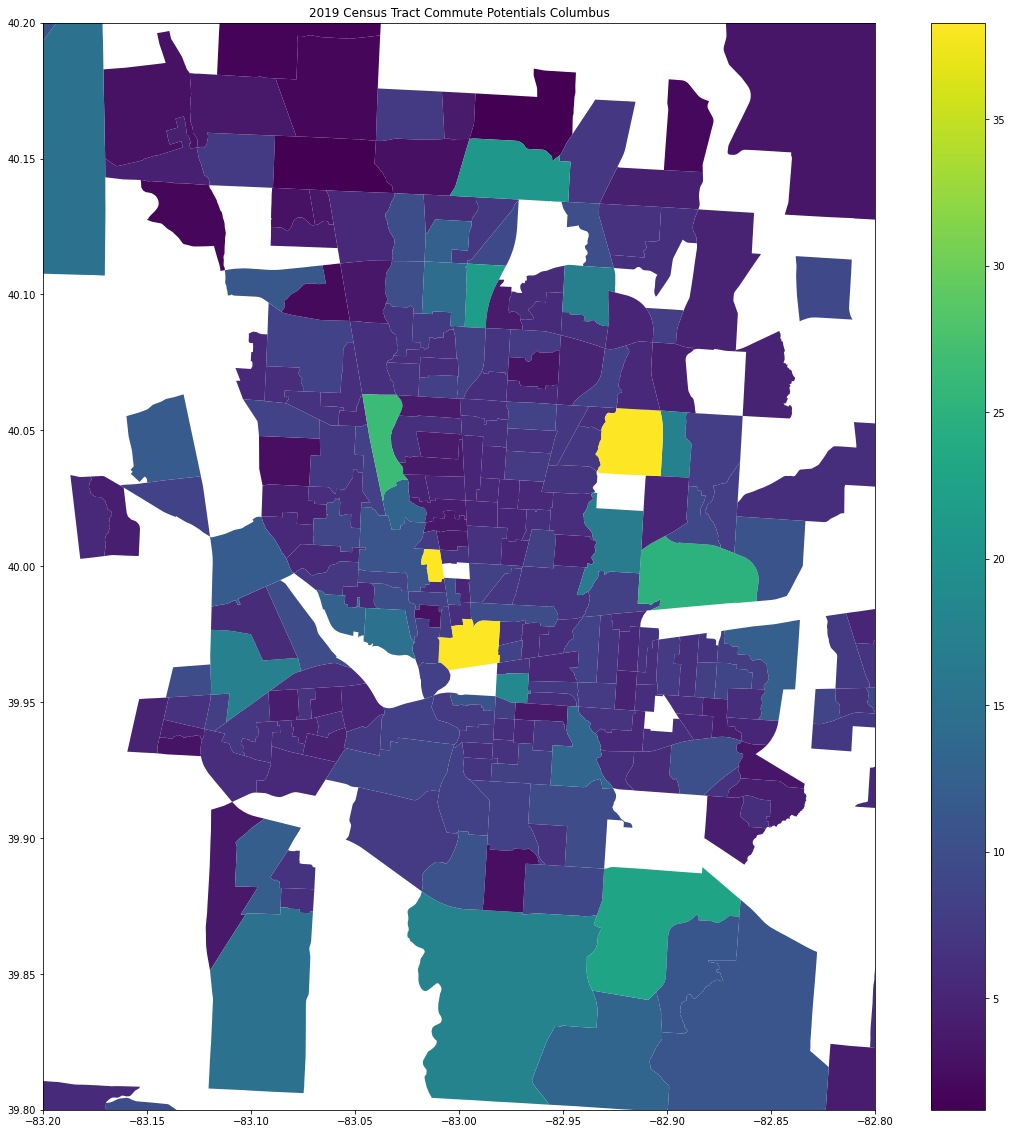

<Figure size 432x288 with 0 Axes>

In [25]:
vertices_potential_df = pd.read_csv("divergence potential results/Columbus census tract divergence potential.csv")
vertices_potential_df["Census Tract"] = vertices_potential_df["Census Tract"].astype(str)
shapefile_path = 'Ohio census tract 2019/tl_2019_39_tract.shp'
gdf_10 = gpd.read_file(shapefile_path)
gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_df["Census Tract"])]
gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
potential_vals = list(vertices_potential_df["Potential"])
norm = Normalize(vmin=np.quantile(potential_vals, 0.005), vmax=np.quantile(potential_vals, 0.995))
gdf_10_2.plot(figsize=(20, 20),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
plt.xlim([-83.2,-82.8])
plt.ylim([39.8,40.2])
plt.title(f"2019 Census Tract Commute Potentials Columbus")
plt.show()
plt.savefig('2019 Census Tract Commute Potentials Columbus')

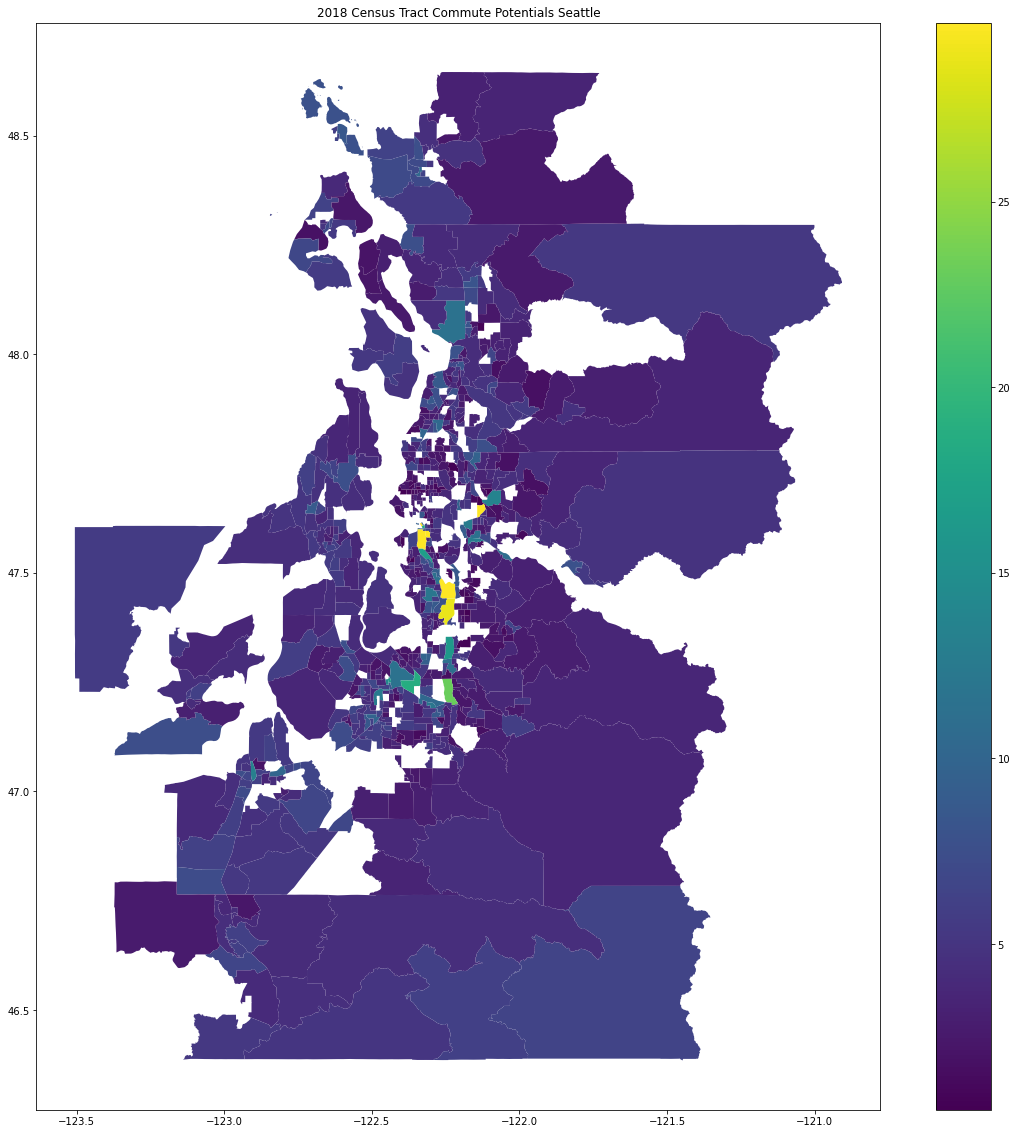

In [27]:
vertices_potential_df = pd.read_csv("divergence potential results/Seattle census tract divergence potential.csv")
vertices_potential_df["Census Tract"] = vertices_potential_df["Census Tract"].astype(str)
shapefile_path = 'Washington census tract 2018/tl_2018_53_tract.shp'
gdf_10 = gpd.read_file(shapefile_path)
gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_df["Census Tract"])]
gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
potential_vals = list(vertices_potential_df["Potential"])
norm = Normalize(vmin=np.quantile(potential_vals, 0.005), vmax=np.quantile(potential_vals, 0.995))
gdf_10_2.plot(figsize=(20, 20),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
# plt.xlim([-83.2,-82.8])
# plt.ylim([39.8,40.2])
plt.title(f"2018 Census Tract Commute Potentials Seattle")
plt.show()
# plt.savefig('2018 Census Tract Commute Potentials Seattle')

In [15]:
vertices_potential_df

,Unnamed: 0,Census Tract,Divergence,Potential
0,0,17031801901,610.970217,4.494996
1,1,17031805111,3721.972383,6.165608
2,2,17031814500,-883.000674,3.278648
3,3,17031480300,-380.968724,4.082486
4,4,17031170100,1374.992255,5.027184
...,...,...,...,...
1791,1791,17031160300,-1461.993541,2.025956
1792,1792,17031161100,-700.006857,3.180296
1793,1793,17043846209,-615.005933,3.709118
1794,1794,17111871304,142.978257,4.895813


In [10]:
vertices_potential_df["Census Tract"]

0       17031801901
1       17031805111
2       17031814500
3       17031480300
4       17031170100
           ...     
1791    17031160300
1792    17031161100
1793    17043846209
1794    17111871304
1795    17031833900
Name: Census Tract, Length: 1796, dtype: int64

C:\Users\DELL\AppData\Local\Temp\ipykernel_15200\2449514782.py:11: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf_10_2.plot(figsize=(20, 20),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)


ValueError: cannot convert float NaN to integer

<Figure size 1440x1440 with 1 Axes>

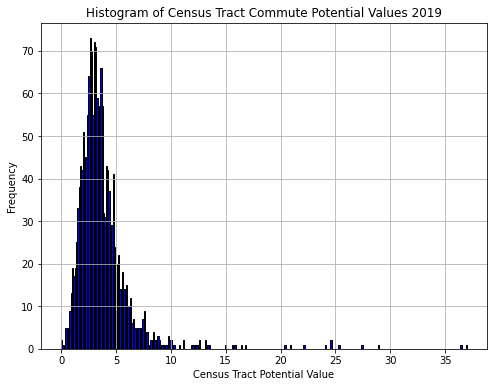

In [52]:
plot_urban_potential_8()